In [1]:
import os

In [2]:

imdb_dir = 'C:/Users/ikram/Desktop/piaic practice/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [3]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="UTF-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 2000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [13]:
glove_dir = 'D:/AI PIAIC/Deep Learning data'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="UTF-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400001 word vectors.


In [14]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7526 - acc: 0.4955 - val_loss: 0.6931 - val_acc: 0.5005
Epoch 2/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7118 - acc: 0.5155 - val_loss: 0.6982 - val_acc: 0.4991
Epoch 3/10
63/63 [==============================] - 1s 21ms/step - loss: 0.6869 - acc: 0.5665 - val_loss: 0.7541 - val_acc: 0.4984
Epoch 4/10
63/63 [==============================] - 1s 18ms/step - loss: 0.6444 - acc: 0.6510 - val_loss: 0.7223 - val_acc: 0.4922
Epoch 5/10
63/63 [==============================] - 1s 16ms/step - loss: 0.5603 - acc: 0.7265 - val_loss: 1.3660 - val_acc: 0.5012
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 0.4938 - acc: 0.7700 - val_loss: 0.7938 - val_acc: 0.4962
Epoch 7/10
63/63 [==============================] - 1s 17ms/step - loss: 0.3810 - acc: 0.8520 - val_loss: 0.7901 - val_acc: 0.4986
Epoch 8/10
63/63 [==============================] - 1s 18ms/step - loss: 0.3055 - a

In [18]:
model.save_weights('pre_trained_glove_model.h5')


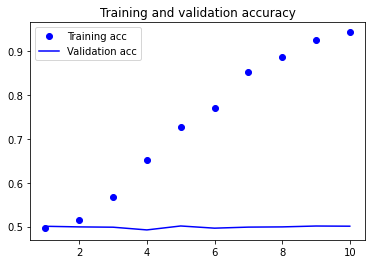

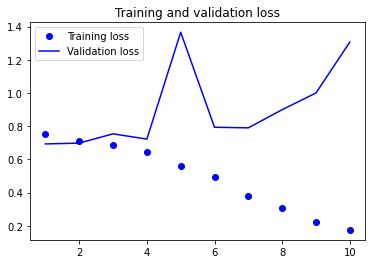

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="UTF-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [21]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.3253 - acc: 0.4976


[1.3252978324890137, 0.4976400136947632]